# Un tweet va a ser popular?
Vamos a investigar si es posible predicir si un Tweet va a ser popular, utilizando los datos descargados en agosto 2021. En general tenemos datos de cuentas famosas y tenemos detalles del usuario ademas de los tweets.

Esto va a ser "modo express" - no vamos a profundizar del todo en todo.

In [1]:
from pathlib import Path
import warnings

import pandas as pd
import plotnine as pn
import numpy as np
from mizani.formatters import percent_format
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


data_loc = Path('../1-descarga-datos/')
users_file = '2021-08-11-handles-data.csv'
tweet_file = '2021-08-11-2021-08-12-2021-08-19-tweets-data.csv'

pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore', module='plotnine')

In [2]:
user_dates = ['join_datetime']
users = pd.read_csv(data_loc / users_file, parse_dates=user_dates)

tweet_dates = ['date']
tweets = pd.read_csv(data_loc / tweet_file, parse_dates=tweet_dates)


/Users/andreas/miniforge3/envs/generic-ds/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
users.head()

,id,name,username,bio,url,join_datetime,join_date,join_time,tweets,location,following,followers,likes,media,private,verified,avatar,background_image
0,409486555,Michelle Obama,MichelleObama,Girl from the South Side and former First Lady...,https://t.co/HPYP9ad13Y,2011-11-10 20:13:01 UTC,2011-11-10,20:13:01 UTC,1770,"Washington, DC",16,20854298,184,461,False,True,https://pbs.twimg.com/profile_images/136674780...,https://pbs.twimg.com/profile_banners/40948655...
1,19397785,Oprah Winfrey,Oprah,NaN,https://t.co/IKOnfAha8E,2009-01-23 15:18:34 UTC,2009-01-23,15:18:34 UTC,13388,NaN,323,43197469,224,951,False,True,https://pbs.twimg.com/profile_images/112335936...,https://pbs.twimg.com/profile_banners/19397785...
2,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
3,14230524,Lady Gaga,ladygaga,“Chromatica” ⚔️💓 OUT NOW https://t.co/dgVb2x2V...,https://t.co/r5yRJxteLd,2008-03-26 22:37:48 UTC,2008-03-26,22:37:48 UTC,9519,NaN,119314,83675119,2310,1795,False,True,https://pbs.twimg.com/profile_images/142258922...,https://pbs.twimg.com/profile_banners/14230524...
4,16409683,Britney Spears,britneyspears,NaN,https://t.co/v9ZAAXrNtg,2008-09-22 20:47:35 UTC,2008-09-22,20:47:35 UTC,5716,"Los Angeles, CA",367095,55569235,2539,1362,False,True,https://pbs.twimg.com/profile_images/132341880...,https://pbs.twimg.com/profile_banners/16409683...


In [4]:
tweets.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1425590913959612419,1425590913959612419,1.628722e+12,2021-08-12 00:52:14,200,NaN,RT @girlsalliance: We're so proud of the four ...,en,[],[],409486555,409486555,MichelleObama,Michelle Obama,4,0,https://twitter.com/MichelleObama/status/14255...,[],[],0,NaN,True,0,0,232,0,None,NaN,NaN,NaN,1.047165e+18,We're so proud of the four organizations in ou...,1.425590e+18,[],2021-08-12 00:46:58 CEST,NaN,NaN,NaN
1,1427736867739299841,1427736867739299841,1.629234e+12,2021-08-17 22:59:29,200,NaN,Some casual suggestions to 😏SLIDE😏 into when u...,en,"['shoesdaytuesday', 'afterskewlslide']",[],21447363,21447363,katyperry,KATY PERRY,2,22,https://twitter.com/katyperry/status/142773686...,[],['https://pbs.twimg.com/media/E9BXG4YVkAAl3_A....,1,https://pbs.twimg.com/media/E9BXG4YVkAAl3_A.jpg,False,5266,368,408,0,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1427667300488937476,1427667300488937476,1.629217e+12,2021-08-17 18:23:03,200,NaN,RT @ValaAfshar: You are not your job.,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766730...,[],[],0,NaN,True,0,0,764,0,None,NaN,NaN,NaN,2.597252e+08,You are not your job.,1.427648e+18,[],2021-08-17 17:05:53 CEST,NaN,NaN,NaN
3,1427667012105371652,1427667012105371652,1.629217e+12,2021-08-17 18:21:55,200,NaN,What have we become 😔😂 Toddler Cites Freedom ...,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766701...,['https://www.theonion.com/toddler-cites-freed...,[],0,NaN,False,5638,476,438,0,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1427497703596990467,1427497703596990467,1.629177e+12,2021-08-17 07:09:08,200,NaN,The tech giants that refuse to massively addre...,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,7,https://twitter.com/katyperry/status/142749770...,[],[],0,NaN,False,8810,546,1211,https://twitter.com/VICENews/status/1427311204...,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [5]:
print(users.shape, users.id.nunique())
print(tweets.shape, tweets.id.nunique())

(1246, 18) 1226
(40581, 38) 40581


Ya vemos que en nuestros datos de los usuarios tenemos algún duplicado - vamos a quitarlo ya, guardando el la ultima fila ordenando por el numero de follows (supongo que followers crece en el tiempo, no?).

In [6]:
users = users.sort_values('followers').drop_duplicates(subset=['id'], keep='last').reset_index(drop=True)

In [7]:
print(users.shape, users.id.nunique())

(1226, 18) 1226


## Lo basico de los datos
Tenemos muchas columnas y muchas seguramente no son interesantes. Vamos a ver primero el `info` de las columnas - ya estoy copiando a vosotros.

In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1226 non-null   int64 
 1   name              1209 non-null   object
 2   username          1209 non-null   object
 3   bio               1099 non-null   object
 4   url               991 non-null    object
 5   join_datetime     1226 non-null   object
 6   join_date         1209 non-null   object
 7   join_time         1209 non-null   object
 8   tweets            1226 non-null   int64 
 9   location          825 non-null    object
 10  following         1226 non-null   int64 
 11  followers         1226 non-null   int64 
 12  likes             1226 non-null   int64 
 13  media             1226 non-null   int64 
 14  private           1209 non-null   object
 15  verified          1209 non-null   object
 16  avatar            1209 non-null   object
 17  background_ima

In [9]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40581 entries, 0 to 40580
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               40581 non-null  int64         
 1   conversation_id  40581 non-null  int64         
 2   created_at       40581 non-null  float64       
 3   date             40581 non-null  datetime64[ns]
 4   timezone         40581 non-null  int64         
 5   place            34 non-null     object        
 6   tweet            40581 non-null  object        
 7   language         40581 non-null  object        
 8   hashtags         40581 non-null  object        
 9   cashtags         40581 non-null  object        
 10  user_id          40581 non-null  int64         
 11  user_id_str      40581 non-null  int64         
 12  username         40581 non-null  object        
 13  name             40581 non-null  object        
 14  day              40581 non-null  int64

In [10]:
users.nunique()

id                  1226
name                1209
username            1209
bio                 1099
url                  987
join_datetime       1210
join_date            806
join_time           1204
tweets              1155
location             517
following            838
followers           1201
likes                931
media               1045
private                2
verified               2
avatar              1190
background_image    1099
dtype: int64

In [11]:
tweets.nunique()

id                 40581
conversation_id    37273
created_at         36756
date               36756
timezone               1
place                 22
tweet              40026
language              40
hashtags            2561
cashtags               4
user_id              847
user_id_str          847
username             847
name                 847
day                    7
hour                  24
link               40581
urls               19576
photos              5344
video                  2
thumbnail           8661
retweet                2
nlikes              4573
nreplies            1258
nretweets           2281
quote_url           2446
search                 1
near                   0
geo                    0
source                 0
user_rt_id          3559
user_rt             6046
retweet_id          6047
reply_to            3576
retweet_date        5972
translate              0
trans_src              0
trans_dest             0
dtype: int64

In [12]:
(users.isin(['', ' '])).mean()

id                  0.000000
name                0.000000
username            0.000000
bio                 0.000000
url                 0.000000
join_datetime       0.013866
join_date           0.000000
join_time           0.000000
tweets              0.000000
location            0.001631
following           0.000000
followers           0.000000
likes               0.000000
media               0.000000
private             0.000000
verified            0.000000
avatar              0.000000
background_image    0.000000
dtype: float64

Hay un par de columnas que son todos nulos y tambien algunas que solo tienen un valor unico. Mirando las columnas parece información que podria ser útil pero es lo que hay - seran cosas deprecadas del API.

Tambien hay varias columnas de texto que por ahora no nos van a interesar - simplemente es un poco "out of scope".

In [13]:
# A veces Pandas es horrible
useless_cols = (tweets.nunique() < 2).reset_index().rename(columns = {0 : 'to_drop'}).query('to_drop')['index'].tolist()

user_text_cols = ['username', 'name', 'bio', 'location', 'avatar', 'background_image', 'url', 'join_date', 'join_time']
tweet_text_cols = ['user_id_str', 'username', 'name', 'link', 'user_rt', 'place']

users = users.drop(user_text_cols, axis=1).reset_index(drop=True)
tweets = tweets.drop(tweet_text_cols + useless_cols, axis=1).reset_index(drop=True)

In [14]:
# Tambien vemos que hay una fecha vacia
users.loc[users.join_datetime == ' ', 'join_datetime'] = np.NaN
users['join_datetime'] = pd.to_datetime(users.join_datetime)

In [15]:
users.head()

,id,join_datetime,tweets,following,followers,likes,media,private,verified
0,1730144024,NaT,-1,-1,-1,-1,-1,NaN,NaN
1,960604713661222913,NaT,-1,-1,-1,-1,-1,NaN,NaN
2,4150039286,NaT,-1,-1,-1,-1,-1,NaN,NaN
3,61003804,NaT,-1,-1,-1,-1,-1,NaN,NaN
4,25073877,NaT,-1,-1,-1,-1,-1,NaN,NaN


In [16]:
tweets.head()

,id,conversation_id,created_at,date,tweet,language,hashtags,cashtags,user_id,day,hour,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,user_rt_id,retweet_id,reply_to,retweet_date
0,1425590913959612419,1425590913959612419,1.628722e+12,2021-08-12 00:52:14,RT @girlsalliance: We're so proud of the four ...,en,[],[],409486555,4,0,[],[],0,NaN,True,0,0,232,0,1.047165e+18,1.425590e+18,[],2021-08-12 00:46:58 CEST
1,1427736867739299841,1427736867739299841,1.629234e+12,2021-08-17 22:59:29,Some casual suggestions to 😏SLIDE😏 into when u...,en,"['shoesdaytuesday', 'afterskewlslide']",[],21447363,2,22,[],['https://pbs.twimg.com/media/E9BXG4YVkAAl3_A....,1,https://pbs.twimg.com/media/E9BXG4YVkAAl3_A.jpg,False,5266,368,408,0,NaN,NaN,[],NaN
2,1427667300488937476,1427667300488937476,1.629217e+12,2021-08-17 18:23:03,RT @ValaAfshar: You are not your job.,en,[],[],21447363,2,18,[],[],0,NaN,True,0,0,764,0,2.597252e+08,1.427648e+18,[],2021-08-17 17:05:53 CEST
3,1427667012105371652,1427667012105371652,1.629217e+12,2021-08-17 18:21:55,What have we become 😔😂 Toddler Cites Freedom ...,en,[],[],21447363,2,18,['https://www.theonion.com/toddler-cites-freed...,[],0,NaN,False,5638,476,438,0,NaN,NaN,[],NaN
4,1427497703596990467,1427497703596990467,1.629177e+12,2021-08-17 07:09:08,The tech giants that refuse to massively addre...,en,[],[],21447363,2,7,[],[],0,NaN,False,8810,546,1211,https://twitter.com/VICENews/status/1427311204...,NaN,NaN,[],NaN


uhhh mira todos estos nulos! Vemos que en los usuarios hay varios que tienen todos nulos. Vamos a quitar estos - seguramente es un error del API. Primero vamos a ver si tenemos algun tweet de ellos.

In [17]:
users.isnull().sum(axis=1).value_counts(normalize=True)

0    0.986134
3    0.013866
dtype: float64

In [18]:
bad_rows = users.isnull().sum(axis=1) == 3

In [19]:
user_ids = users.loc[bad_rows, 'id']
tweets[tweets.user_id.isin(user_ids)]

,id,conversation_id,created_at,date,tweet,language,hashtags,cashtags,user_id,day,hour,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,user_rt_id,retweet_id,reply_to,retweet_date


In [20]:
users = users[~bad_rows].reset_index(drop=True)

Vemos que no tienen ningun tweet de todas formas asi que no pasa nada. Vamos a ver si algo similar pasa en los tweets.

In [21]:
tweets.isnull().sum(axis=1).value_counts(normalize=True)

4    0.649885
3    0.198640
1    0.124516
0    0.026958
dtype: float64

No parece.

Como ultimo check vamos a ver que todos los usuarios de nuestros tweets estan en la base de usuarios.

In [22]:
tweet_users = pd.Series(tweets.user_id.unique())
tweet_users.isin(users.id.unique()).mean()

1.0

Esta todo bien.

## Vamos a entender mejor nuestros tweets
Hemos visto que los datos más o menos tienen sentido. Vamos ahora a analizar un poco más en el contexto del mundo real.

### Como son nuestros usuarios?
Lo primero es ver que tal se distribuyen nuestros usuarios.

In [23]:
(users.private.value_counts(normalize=True).round(2) * 100).astype(int).astype(str) + '%'

False    99%
True      1%
Name: private, dtype: object

In [24]:
(users.verified.value_counts(normalize=True).round(2) * 100).astype(int).astype(str) + '%'

True     91%
False     9%
Name: verified, dtype: object

In [25]:
cont_cols = ['tweets', 'following', 'followers', 'likes', 'media']
users[cont_cols].describe(percentiles=[0.9, 0.95, 0.99]).astype(int)

,tweets,following,followers,likes,media
count,1209,1209,1209,1209,1209
mean,28624,10148,8132383,6040,6327
std,59597,132866,12578418,23323,24477
min,0,0,0,0,0
50%,11117,492,4459113,862,1499
90%,60497,4261,16942348,13329,7697
95%,109883,12565,29776022,25415,23411
99%,348896,133135,64875553,68441,118501
max,730463,4200793,129909278,492144,516329


In [26]:
users['join_datetime_year'] = users.join_datetime.dt.year
(users.join_datetime_year.value_counts(normalize=True).sort_index().round(2) * 100).astype(int).astype(str) + '%'

2006     0%
2007     6%
2008    10%
2009    43%
2010    18%
2011    11%
2012     5%
2013     2%
2014     1%
2015     1%
2016     1%
2017     1%
2018     1%
2019     0%
2020     1%
2021     0%
Name: join_datetime_year, dtype: object

Aquí vemos varias cosas:

* Casi ninguna cuenta es privada (normal, si fuera asi no sé como tendriamos los datos?)
* Un 90% son verificados, que tambien tiene sentido ya que son cuentas famosas, pero es un dato guay tener
* Las columnas de info sobre los followers, following y tweets son interesantes - generalmente tenemos muchisimos outliers, como por ejemplo el maximo siendo el doble que el 99%
* Tambien vemos que los followers son muy altos en general mientras las demas columnas tienen un poco mas de rango de valores
* La mayoria de las cuentas son de 2008 - 2011, que es cuando Twitter empezo a ganar mucha popularidad

Vamos a ver los tweets

### Los tweets
Para empezar - he visto que hay retweets - vamos a verlos.

In [27]:
tweets[tweets.retweet].head()

,id,conversation_id,created_at,date,tweet,language,hashtags,cashtags,user_id,day,hour,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,user_rt_id,retweet_id,reply_to,retweet_date
0,1425590913959612419,1425590913959612419,1.628722e+12,2021-08-12 00:52:14,RT @girlsalliance: We're so proud of the four ...,en,[],[],409486555,4,0,[],[],0,NaN,True,0,0,232,0,1.047165e+18,1.425590e+18,[],2021-08-12 00:46:58 CEST
2,1427667300488937476,1427667300488937476,1.629217e+12,2021-08-17 18:23:03,RT @ValaAfshar: You are not your job.,en,[],[],21447363,2,18,[],[],0,NaN,True,0,0,764,0,2.597252e+08,1.427648e+18,[],2021-08-17 17:05:53 CEST
5,1426598917471305735,1426598917471305735,1.628963e+12,2021-08-14 19:37:41,RT @peterdaou: An Italian town hit 124 degrees...,en,['climateemergency'],[],21447363,6,19,[],[],0,NaN,True,0,0,430,0,1.846427e+07,1.426281e+18,[],2021-08-13 22:32:52 CEST
9,1427758371873202177,1427758371873202177,1.629239e+12,2021-08-18 00:24:56,RT @mrtimchan: Wrote about @MariahCarey's new ...,en,[],[],19248106,3,0,[],[],0,NaN,True,0,0,176,0,4.543648e+08,1.427443e+18,[],2021-08-17 03:29:49 CEST
10,1427757856661594114,1427757856661594114,1.629239e+12,2021-08-18 00:22:54,RT @foodandwine: Best paired with your favorit...,en,[],[],19248106,3,0,['https://www.foodandwine.com/news/mariah-care...,[],0,NaN,True,0,0,295,0,3.027853e+07,1.427677e+18,[],2021-08-17 19:00:09 CEST


In [28]:
tweets.loc[tweets.retweet, ['nlikes', 'nreplies', 'nretweets']].describe()

,nlikes,nreplies,nretweets
count,6147.0,6147.0,6147.000000
mean,0.0,0.0,538.854238
std,0.0,0.0,3085.250851
min,0.0,0.0,1.000000
25%,0.0,0.0,8.000000
50%,0.0,0.0,30.000000
75%,0.0,0.0,154.000000
max,0.0,0.0,113226.000000


Interesante! Parece ser que estos datos son ligeramente diferentes a los demas. Aqui tenemos 3 opciones:

* Mantener estos datos y hacer nada --> mala opcion, mezclar tipos de datos no es buena idea
* Mantener estos datos y scrapear la informacion "correcta" del tweet original (por ejemplo, no tenemos el numero de seguidores del usuario original) --> buena opcion, pero costoso
* Quitarlos --> una opcion mala pero rapido y mejor que la primera, ding ding ding, we have a winner!

In [29]:
tweets = tweets[~tweets.retweet].reset_index(drop=True)

Tambien vamos a mirar la columna de "conversation_id" porque parece tener algo que ver con que sean respuestas.

In [30]:
tweets['same_convo_id'] = tweets.id == tweets.conversation_id
tweets['has_reply_to'] = tweets.reply_to != '[]'

In [31]:
tweets.groupby('has_reply_to').same_convo_id.value_counts(normalize=True)

has_reply_to  same_convo_id
False         True             0.957715
              False            0.042285
True          False            1.000000
Name: same_convo_id, dtype: float64

In [32]:
tweets.groupby('has_reply_to').same_convo_id.value_counts()

has_reply_to  same_convo_id
False         True             29172
              False             1288
True          False             3974
Name: same_convo_id, dtype: int64

Podemos ver que por lo menos todos los que tienen un "reply to" no tienen la conversion id igual. Los otros ejemplos no sé que pueden ser.

In [33]:
tweets[tweets.has_reply_to].head()

,id,conversation_id,created_at,date,tweet,language,hashtags,cashtags,user_id,day,hour,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,user_rt_id,retweet_id,reply_to,retweet_date,same_convo_id,has_reply_to
4,1427927723356430337,1427904450136510464,1.629279e+12,2021-08-18 11:37:53,@Jefflez @LeroyAhBen Love you !!!,en,[],[],19248106,3,11,[],[],0,NaN,False,375,29,35,0,NaN,NaN,"[{'screen_name': 'Jefflez', 'name': 'Jeffrey I...",NaN,False,True
111,1427109341753139205,1427102755412393985,1.629084e+12,2021-08-16 05:25:56,@EliLake Honestly don’t know. But I asked what...,en,[],[],150078976,1,5,[],[],0,NaN,False,12,5,3,0,NaN,NaN,"[{'screen_name': 'EliLake', 'name': 'Eli Lake'...",NaN,False,True
112,1427104985997840384,1427102755412393985,1.629083e+12,2021-08-16 05:08:37,@EliLake Are you referring to the unsourced re...,en,[],[],150078976,1,5,[],[],0,NaN,False,11,4,0,0,NaN,NaN,"[{'screen_name': 'EliLake', 'name': 'Eli Lake'...",NaN,False,True
223,1426347545119232003,1426223408749088772,1.628903e+12,2021-08-14 02:58:49,@Bob_Casey @ReverendWarnock Sorry I had missed...,en,[],[],47747074,6,2,[],[],0,NaN,False,777,4,24,0,NaN,NaN,"[{'screen_name': 'Bob_Casey', 'name': 'Bob Cas...",NaN,False,True
521,1425655357318258689,1425554543929176072,1.628738e+12,2021-08-12 05:08:19,@Makeublush DM me,en,[],[],16160352,4,5,[],[],0,NaN,False,3,0,0,0,NaN,NaN,"[{'screen_name': 'Makeublush', 'name': 'Barbar...",NaN,False,True


Ahora vamos a hacer lo mismo - vamos a quitar estos tweets. Esto ya esta un poco menos claro pero seguiendo la mismoa logica que antes y el concepto del proyecto - no me parece 100% correcto estar mezclando respuestas con tweets normales.

Aqui otra opcion podria ser entrenar un modelo separado para las respuestas, pero por tiempo no lo vamos a hacer.

In [34]:
tweets = tweets[~tweets.has_reply_to].reset_index(drop=True)

In [35]:
tweets.shape

(30460, 26)

En total hemos quitado aproximadamente 10k tweets - un numero importante! Pero creo que el problema se quedara mejor definido.

Progresamos a explorar los tweets - esto es lo divertido!

In [36]:
tweets['tweet_length'] = tweets.tweet.str.len()

tweets['num_hashtags'] = (tweets.hashtags.str.extractall('(,)').reset_index().groupby('level_0').match.max() + 1)
tweets['num_hashtags'] = tweets.num_hashtags.fillna(0)

tweets['num_cashtags'] = (tweets.cashtags.str.extractall('(,)').reset_index().groupby('level_0').match.max() + 1)
tweets['num_cashtags'] = tweets.num_cashtags.fillna(0)

tweets['num_urls'] = (tweets.urls.str.extractall('(,)').reset_index().groupby('level_0').match.max() + 1)
tweets['num_urls'] = tweets.num_urls.fillna(0)

tweets['num_photos'] = (tweets.photos.str.extractall('(,)').reset_index().groupby('level_0').match.max() + 1)
tweets['num_photos'] = tweets.num_photos.fillna(0)

tweets['has_quotes'] = tweets.quote_url != '0'

tweets['has_thumbnail'] = tweets.thumbnail.notna()

tweets['day'] = tweets.date.dt.date

tweet_counts = tweets.tweet.value_counts().reset_index().rename(columns={'tweet' : 'number_times_repeated', 'index' : 'tweet'})
tweets = tweets.merge(tweet_counts, how='left')

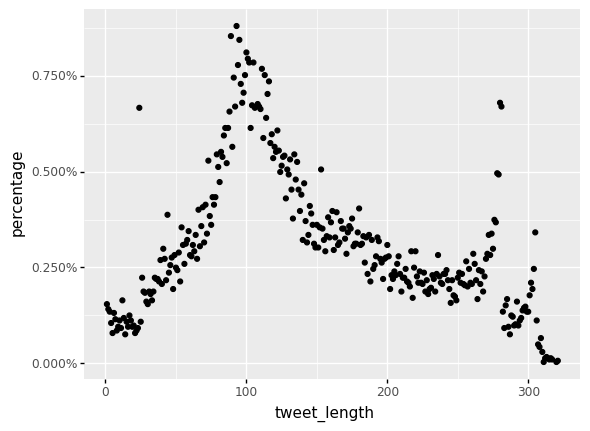

In [37]:
graph_data = tweets.groupby('tweet_length').id.nunique().reset_index()
graph_data['percentage'] = graph_data.id / graph_data.id.sum()

graph = (
    pn.ggplot(graph_data, pn.aes(x='tweet_length', y='percentage'))
    + pn.geom_point()
    + pn.scale_y_continuous(labels=percent_format())
)

graph.draw();

3.5% of tweets with a hashtag


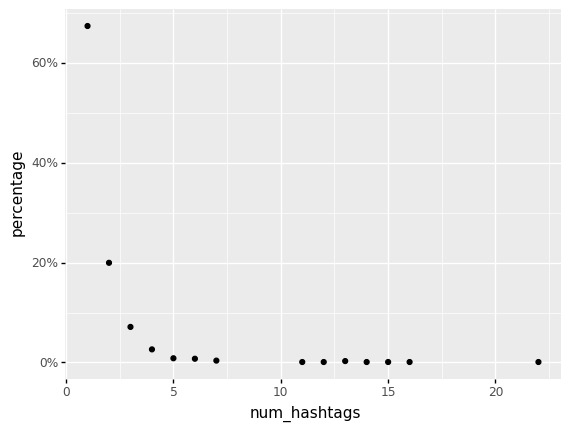

In [38]:
print('{:.1%} of tweets with a hashtag'.format((tweets.num_hashtags > 0).mean()))

graph_data = tweets[tweets.num_hashtags > 0].groupby('num_hashtags').id.nunique().reset_index()
graph_data['percentage'] = graph_data.id / graph_data.id.sum()

graph = (
    pn.ggplot(graph_data, pn.aes(x='num_hashtags', y='percentage'))
    + pn.geom_point()
    + pn.scale_y_continuous(labels=percent_format())
)

graph.draw();

0.0% of tweets with a cashtag


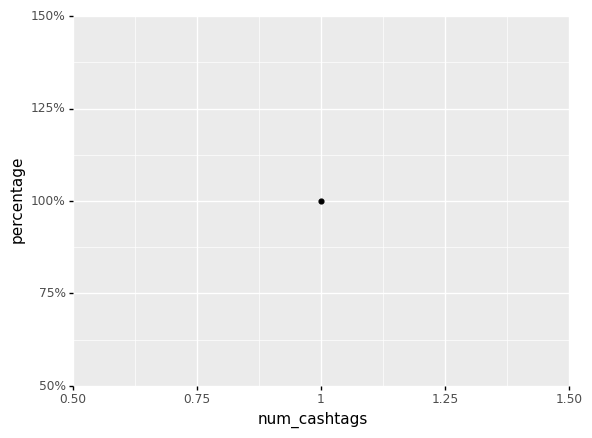

In [39]:
print('{:.1%} of tweets with a cashtag'.format((tweets.num_cashtags > 0).mean()))

graph_data = tweets[tweets.num_cashtags > 0].groupby('num_cashtags').id.nunique().reset_index()
graph_data['percentage'] = graph_data.id / graph_data.id.sum()

graph = (
    pn.ggplot(graph_data, pn.aes(x='num_cashtags', y='percentage'))
    + pn.geom_point()
    + pn.scale_y_continuous(labels=percent_format())
)

graph.draw();

0.8% of tweets with a URL


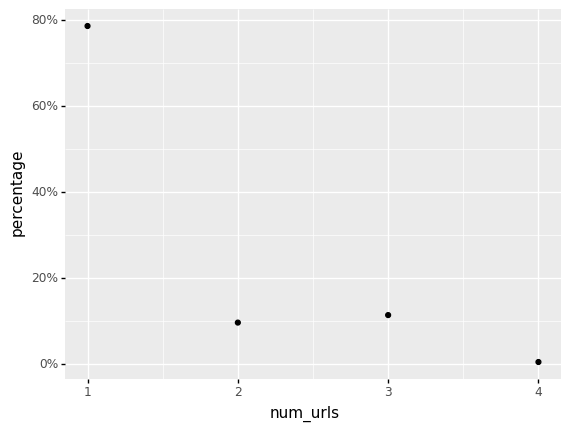

In [40]:
print('{:.1%} of tweets with a URL'.format((tweets.num_urls > 0).mean()))

graph_data = tweets[tweets.num_urls > 0].groupby('num_urls').id.nunique().reset_index()
graph_data['percentage'] = graph_data.id / graph_data.id.sum()

graph = (
    pn.ggplot(graph_data, pn.aes(x='num_urls', y='percentage'))
    + pn.geom_point()
    + pn.scale_y_continuous(labels=percent_format())
)

graph.draw();

2.0% of tweets with a photo


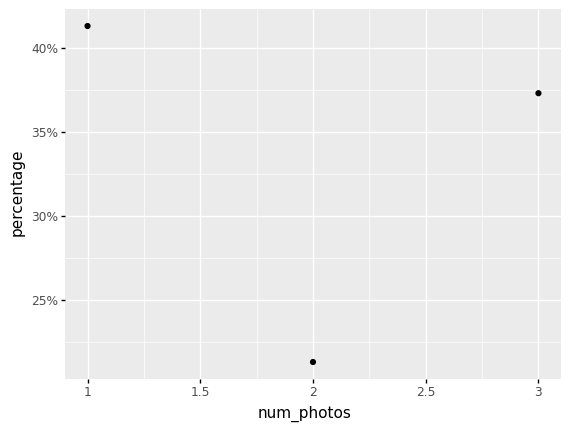

In [41]:
print('{:.1%} of tweets with a photo'.format((tweets.num_photos > 0).mean()))

graph_data = tweets[tweets.num_photos > 0].groupby('num_photos').id.nunique().reset_index()
graph_data['percentage'] = graph_data.id / graph_data.id.sum()

graph = (
    pn.ggplot(graph_data, pn.aes(x='num_photos', y='percentage'))
    + pn.geom_point()
    + pn.scale_y_continuous(labels=percent_format())
)

graph.draw();

2.5% of tweets were repeated


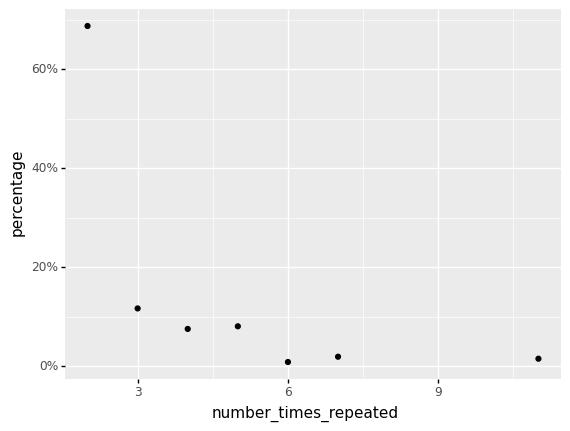

In [42]:
print('{:.1%} of tweets were repeated'.format((tweets.number_times_repeated > 1).mean()))

graph_data = tweets[tweets.number_times_repeated > 1].groupby('number_times_repeated').id.nunique().reset_index()
graph_data['percentage'] = graph_data.id / graph_data.id.sum()

graph = (
    pn.ggplot(graph_data, pn.aes(x='number_times_repeated', y='percentage'))
    + pn.geom_point()
    + pn.scale_y_continuous(labels=percent_format())
)

graph.draw();

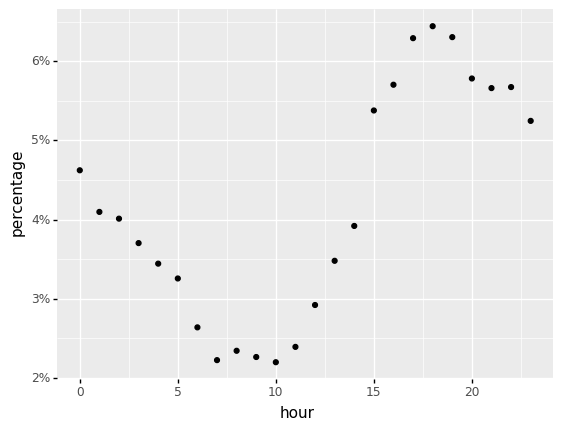

In [43]:
graph_data = tweets.groupby('hour').id.nunique().reset_index()
graph_data['percentage'] = graph_data.id / graph_data.id.sum()

graph = (
    pn.ggplot(graph_data, pn.aes(x='hour', y='percentage'))
    + pn.geom_point()
    + pn.scale_y_continuous(labels=percent_format())
)

graph.draw();

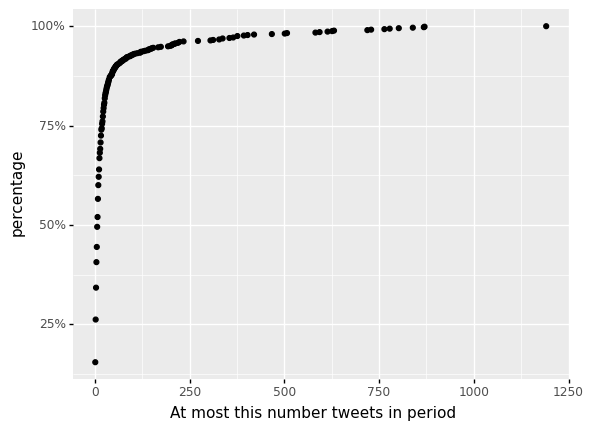

In [44]:
graph_data = tweets.groupby('user_id').id.nunique().reset_index().groupby('id').user_id.nunique().reset_index()
graph_data['percentage'] = (graph_data.user_id / graph_data.user_id.sum()).cumsum()

graph = (
    pn.ggplot(graph_data, pn.aes(x='id', y='percentage'))
    + pn.geom_point()
    + pn.scale_y_continuous(labels=percent_format())
    + pn.xlab('At most this number tweets in period')
)

graph.draw();

In [45]:
(tweets.has_quotes.value_counts(normalize=True).round(2) * 100).astype(int).astype(str) + '%'

False    93%
True      7%
Name: has_quotes, dtype: object

In [46]:
(tweets.has_thumbnail.value_counts(normalize=True).round(2) * 100).astype(int).astype(str) + '%'

False    74%
True     26%
Name: has_thumbnail, dtype: object

In [47]:
(tweets.day.value_counts(normalize=True).sort_index().round(2) * 100).astype(int).astype(str) + '%'

2021-08-12    16%
2021-08-13    16%
2021-08-14    11%
2021-08-15    11%
2021-08-16    14%
2021-08-17    16%
2021-08-18    16%
2021-08-19     0%
Name: day, dtype: object

In [48]:
(tweets.video.value_counts(normalize=True).sort_index().round(2) * 100).astype(int).astype(str) + '%'

0    74%
1    26%
Name: video, dtype: object

In [49]:
tweets[tweets.video == 1].has_thumbnail.mean()

1.0

In [50]:
tweets[tweets.has_thumbnail == 1].video.mean()

1.0

Muchas cosas!

* Los longitudes de los tweets se distribuyen con unos picos, que es curioso
* Muy pocos tweets tienen hashtags, urls, photos etc. --> dentro de todo esto una cosa interesante es que hay varios tweets que se han repetido varias veces, posiblemente es spam?
* Hay picos de tweets despues de las 15:00, la hora normal de estar en twitter supongo --> nota que esta hora sera en UTC o algo, asi que realmente haria falta transformar a hora local, pero nuestro campo de zona horaria estaba vacia
* Hay algunos usuarios que han tweeteado un monton!
* Vemos que es un poco mas comun tener quotes, y bastante normal tener thumbnails o un video --> de hecho, siempre coinciden estas columnas!
* Y la distribucion de tweets es muy estable en el tiempo

Vamos ahora a echar un vistazo a las columnas continuas

In [51]:
cont_cols = ['nlikes', 'nreplies', 'nretweets']
tweets[cont_cols].describe(percentiles=[0.9, 0.95, 0.99]).astype(int)

,nlikes,nreplies,nretweets
count,30460,30460,30460
mean,1702,93,254
std,20745,1011,5164
min,0,0,0
50%,75,8,18
90%,2114,140,294
95%,5831,312,797
99%,30254,1398,3677
max,1920242,88035,541964


In [52]:
((tweets[cont_cols] == 0).mean() * 100).round(1).astype(str) + '%'

nlikes        0.5%
nreplies     13.7%
nretweets     3.8%
dtype: object

Aqui vemos otra vez que hay unos outliers muy fuertes! Como estas columnas seran las bases de nuestro target, esto es muy importante. Tambien observamos que hay bastantes con valor 0 - especialemente los "nreplies".

### Resumiendo
Vamos a quitar las columnas que no nos interesan para simplificar un poco en general.

En este momento tambien vamos a hacer nuestro merge para combinar la info de los usuarios con los tweets.

In [53]:
tweets['number_tweets_in_period'] = tweets.groupby('user_id').id.transform('nunique')

In [54]:
keep_users = [col for col in users if col != 'join_datetime']
keep_tweets = ['id', 'tweet', 'user_id', 'day', 'hour', 'language', 'video', 'num_hashtags', 'tweet_length', 'num_photos', 'has_quotes', 'same_convo_id', 'number_times_repeated', 'number_tweets_in_period'] + cont_cols

users = users[keep_users].reset_index(drop=True)
tweets = tweets[keep_tweets].reset_index(drop=True)

to_drop = ['id_user']
final_data = tweets.merge(users, left_on='user_id', right_on='id', suffixes=['', '_user']).drop(to_drop, axis=1)

In [55]:
final_data.head()

,id,tweet,user_id,day,hour,language,video,num_hashtags,tweet_length,num_photos,has_quotes,same_convo_id,number_times_repeated,number_tweets_in_period,nlikes,nreplies,nretweets,tweets,following,followers,likes,media,private,verified,join_datetime_year
0,1427736867739299841,Some casual suggestions to 😏SLIDE😏 into when u...,21447363,2021-08-17,22,en,1,1.0,164,3.0,False,True,1,3,5266,368,408,11420,235,108819032,7995,2170,False,True,2009
1,1427667012105371652,What have we become 😔😂 Toddler Cites Freedom ...,21447363,2021-08-17,18,en,0,0.0,104,0.0,False,True,1,3,5638,476,438,11420,235,108819032,7995,2170,False,True,2009
2,1427497703596990467,The tech giants that refuse to massively addre...,21447363,2021-08-17,7,en,0,0.0,157,0.0,True,True,1,3,8810,546,1211,11420,235,108819032,7995,2170,False,True,2009
3,1425588921233133572,Thank you @MTV @vmas! ⚔️💓 https://t.co/iyo2KW...,14230524,2021-08-12,0,en,1,0.0,50,0.0,False,True,1,1,42860,1124,5360,9519,119314,83675119,2310,1795,False,True,2008
4,1427806400919580672,Why would anyone be shocked that I’m drinking ...,19248106,2021-08-18,3,en,1,0.0,160,0.0,False,True,1,8,8723,339,965,10252,188,21612341,4346,2504,False,True,2009


## El target
Ahora tenemos que ver que cogemos como el target. Ya hemos visto las 3 principales datos de interes y que tienen muchos outliers. Tambien hemos visto que algunos son 0 y otros no.

Esto ya es un tema muy abierto porque podriamos hacer casi cualquier cosa. Yo estoy pensando varias cosas:

* Tener outliers muy fuertes nos va a joder la regresion
* No está 100% claro que significa "popularidad" - inicialmente la idea que tenian los clientes era contestar al tweet con contenido interesante, asi que quizas el numero de respuestas puede interesar (o quizas mejor tener pocas respuestas, para garantizar que llegamos antes de la gran ola de comentarios iniciales?)
* Puede haber tweets que parecen populares en alguna de nuestras medidas y no la otra, pero la escala de cada uno es muy diferente

In [56]:
cont_cols = ['nlikes', 'nreplies', 'nretweets']
tweets[cont_cols].quantile([0.7, 0.8, 0.9, 0.95, 0.99]).astype(int)

,nlikes,nreplies,nretweets
0.70,226,28,52
0.80,526,56,104
0.90,2114,140,294
0.95,5831,312,797
0.99,30254,1398,3677


Que valores podrian calificar como popular? igual apartir de 500 likes, 50 replies, y 100 retweets?

In [57]:
tweets.loc[tweets[cont_cols[0]] == 0, cont_cols].describe(percentiles=[0.9, 0.95, 0.99]).astype(int)

,nlikes,nreplies,nretweets
count,161,161,161
mean,0,0,0
std,0,1,0
min,0,0,0
50%,0,0,0
90%,0,2,1
95%,0,3,2
99%,0,7,3
max,0,8,3


In [58]:
tweets.loc[tweets[cont_cols[1]] == 0, cont_cols].describe(percentiles=[0.9, 0.95, 0.99]).astype(int)

,nlikes,nreplies,nretweets
count,4172,4172,4172
mean,38,0,10
std,186,0,28
min,0,0,0
50%,11,0,3
90%,68,0,16
95%,163,0,64
99%,351,0,150
max,6651,0,374


In [59]:
tweets.loc[tweets[cont_cols[2]] == 0, cont_cols].describe(percentiles=[0.9, 0.95, 0.99]).astype(int)

,nlikes,nreplies,nretweets
count,1153,1153,1153
mean,9,1,0
std,18,2,0
min,0,0,0
50%,4,0,0
90%,20,3,0
95%,34,5,0
99%,81,10,0
max,310,45,0


Aqui vemos que pasa cuando algun valor es 0 - parece ser que si los likes son 0, realmente es muy poco probable que sea el tweet popular en las otras medidas. Para los replies y retweets, si son 0, tampoco parece que el tweet va a ser muy popular, aunque la relacion es menos fuerte que para los likes.

Esto entonces parece significar que "un tweet no va a ser popular si no es popular en cualquier de las medidas" (solo hemos visto para cuando es igual a 0, pero podemos asumir que la relacion seguiria asi para valores bajos tambien).

In [60]:
tweets.loc[tweets[cont_cols[0]] > tweets[cont_cols[0]].quantile(0.8), cont_cols].describe(percentiles=[0.25, 0.9]).astype(int)

,nlikes,nreplies,nretweets
count,6088,6088,6088
mean,8143,398,1172
std,45842,2235,11506
min,527,0,2
25%,972,47,132
50%,2119,113,292
90%,16234,752,2169
max,1920242,88035,541964


In [61]:
tweets.loc[tweets[cont_cols[1]] > tweets[cont_cols[1]].quantile(0.8), cont_cols].describe(percentiles=[0.25, 0.9]).astype(int)

,nlikes,nreplies,nretweets
count,6054,6054,6054
mean,7760,426,1145
std,46020,2237,11540
min,7,57,1
25%,433,85,92
50%,1503,141,247
90%,16227,765,2172
max,1920242,88035,541964


In [62]:
tweets.loc[tweets[cont_cols[2]] > tweets[cont_cols[2]].quantile(0.8), cont_cols].describe(percentiles=[0.25, 0.9]).astype(int)

,nlikes,nreplies,nretweets
count,6064,6064,6064
mean,7996,397,1193
std,45956,2239,11527
min,41,0,105
25%,696,49,160
50%,1941,114,296
90%,16259,752,2172
max,1920242,88035,541964


Vemos aqui que cuando uno de los valores es alto, tambien parece que los demas van a ser altos (por ejemplo, el percentil 25% es mas o menos donde deciamos que podriamos considerar que un tweet sea "popular").

Con estos resultados me siento comodo solo cogiendo un target ya que la interpretacion de tal target sera un poco mas facil (o sea, mas facil interpretar que predecimos los likes que la media ponderada de las 3 cosas).

Finalmente creo que cogere el numero de likes, simplemente porque tiene menos 0s y asi sera un poco mas facil para la regresion. Ahora bien - tendremos que quitar algunos de los outliers antes de entrenar.

### Separando train y test
Antes de nada vamos a separar train y test para mantener todo mas limpio.

Me di cuenta de algo importante! Nuestras colmnas que cuentan los tweets tienen en cuenta datos de test (tecnicamente), asi que tendremos que volver a hacer el calculo para evitar leaking.

Voy a hacer esto por fechas - simplemente porque para nuestras variables que calculan agregaciones, sera mas limpio. Tenemos 7 dias, asi que podriamos coger 3 dias para train, 2 para validacion y 2 para test. Nota - no es necesario hacer esto por fechas, especialmente como tenemos pocos dias, pero quiero ver si las variables agregadas son buenas o no.

In [63]:
train_days = ['2021-08-12', '2021-08-13', '2021-08-14']
val_days = ['2021-08-15', '2021-08-16']
test_days = ['2021-08-17', '2021-08-18']

renew_cols = ['number_tweets_in_period', 'number_times_repeated']
train = final_data[final_data.day.astype(str).isin(train_days)].reset_index(drop=True).drop(renew_cols, axis=1)
val = final_data[final_data.day.astype(str).isin(val_days)].reset_index(drop=True).drop(renew_cols, axis=1)
test = final_data[final_data.day.astype(str).isin(test_days)].reset_index(drop=True).drop(renew_cols, axis=1)

print(train.shape)
print(val.shape)
print(test.shape)

(13228, 23)
(7552, 23)
(9675, 23)


In [64]:
tweet_counts = train.tweet.value_counts().reset_index().rename(columns={'tweet' : 'number_times_repeated', 'index' : 'tweet'})
train = train.merge(tweet_counts, how='left')
val = val.merge(tweet_counts, how='left')
test = test.merge(tweet_counts, how='left')

user_tweets = train.groupby('user_id').id.nunique().reset_index().rename(columns={'id' : 'number_tweets_in_period'})
train = train.merge(user_tweets, how='left')
val = val.merge(user_tweets, how='left')
test = test.merge(user_tweets, how='left')

# Vamos a tener nulos porque habran usuarios / tweets que aparecen por primera vez - a estos les tenemos que poner un 0 pero tambien sumar 1 a todos!
val[renew_cols] = val[renew_cols].fillna(0) + 1
test[renew_cols] = test[renew_cols].fillna(0) + 1

### Analizando relevancia de variables
Ahora que tenemos todo bien separado, vamos a ver que factores influyen sobre el target. 

Primero voy a reducir los outliers pero solo en train. Hago esto poniendo un tope al valor que voy a fijar en el percentil 95. Esto me parece sensato y va a ayudar en el training.

In [65]:
target = 'nlikes'
train[target] = train[target].clip(upper=train[target].quantile(0.95))

Ahora vamos a echar un vistazo en como de importantes pueden ser algunas variables. Esto va a actuar como un primer "filtro" de las variables que pueden llegar a ser importantes.

In [66]:
cat_vars = ['hour', 'language', 'video', 'num_hashtags', 'num_photos', 'has_quotes', 'same_convo_id', 'verified', 'join_datetime_year', 'number_times_repeated']
cont_vars = ['number_tweets_in_period', 'tweet_length', 'tweets', 'following', 'followers', 'likes', 'media', 'private']

In [67]:
for variable in cat_vars:
    result = train.groupby(variable)[target].agg(['count', 'mean', 'median', 'sem']).round().reset_index()
    
    # Quiero eliminar los que tienen muy poca muestra
    result = result[result['count'] > 100]
    print(result)
    print('\n')

    hour  count   mean  median   sem
0      0    647  499.0    60.0  47.0
1      1    581  539.0    65.0  55.0
2      2    580  468.0    67.0  50.0
3      3    506  636.0    72.0  63.0
4      4    433  639.0    72.0  70.0
5      5    442  727.0    82.0  73.0
6      6    376  578.0    70.0  71.0
7      7    289  520.0    74.0  77.0
8      8    300  659.0    90.0  82.0
9      9    306  684.0    73.0  82.0
10    10    303  752.0    95.0  88.0
11    11    321  810.0    90.0  90.0
12    12    368  878.0    82.0  91.0
13    13    404  679.0    70.0  79.0
14    14    507  676.0    74.0  67.0
15    15    744  720.0    81.0  56.0
16    16    776  564.0    73.0  47.0
17    17    810  555.0    62.0  47.0
18    18    796  608.0    69.0  49.0
19    19    853  621.0    67.0  49.0
20    20    776  542.0    63.0  45.0
21    21    755  682.0    54.0  55.0
22    22    691  740.0    64.0  61.0
23    23    664  811.0    81.0  65.0


   language  count    mean  median    sem
0        ar    404   608.0   17

In [68]:
interesting_cats = ['language', 'video', 'has_quotes', 'verified', 'join_datetime_year']

Mirando los resultados, veo que hay columnas con poca muestra o que las diferencias de medias no son muy importantes (o sea, la diferencia no es bastante grande comparando con el standard error).

In [69]:
train[[target] + cont_vars].corr()['nlikes']

nlikes                     1.000000
number_tweets_in_period   -0.342478
tweet_length              -0.017472
tweets                    -0.347574
following                 -0.012992
followers                  0.261038
likes                     -0.015413
media                     -0.249929
Name: nlikes, dtype: float64

In [70]:
interesting_cont = ['number_tweets_in_period', 'tweets', 'followers']

Haciendo lo mismo - estas columnas me parecen interesantes. Hay que decir que para esta variable es importante reconocer que una correlacion estandar no es perfecta - el `tweet_length` por ejemplo tiene un patron raro y esto puede influir. De todas formas, ya tenemos bastantes variables asi que no hace falta profundizar mucho mas.

#### Creando variables y tratando los datos
Ahora tenemos una idea de mas o menos que columnas pueden ser utiles. Vamos a progresar a crear un par de variables mas y tambien tratar algunos de los datos - como por ejemplo los followers, que sabemos que tiene outliers.

Tambien (y lo que hacemos para empezar) hay que mirar si nuestras variables interesantes tienen mucha correlacion entre ellas - por ejemplo followers y tweets.

In [71]:
train[interesting_cont + ['join_datetime_year']].corr()

,number_tweets_in_period,tweets,followers,join_datetime_year
number_tweets_in_period,1.000000,0.828562,0.095518,-0.292635
tweets,0.828562,1.000000,0.226993,-0.431421
followers,0.095518,0.226993,1.000000,-0.199166
join_datetime_year,-0.292635,-0.431421,-0.199166,1.000000


In [72]:
# Esto se podria hacer con un pipeline pero bueno, asi esta OK tambien
outlier_capping = {
    'tweets' : train.tweets.quantile(0.95),
    'followers' : train.followers.quantile(0.95),
    'media' : train.media.quantile(0.95),
    'likes' : train.likes.quantile(0.95)
}

for outlier_cap in outlier_capping:
    train[outlier_cap + '_capped'] = train[outlier_cap].clip(upper=outlier_capping[outlier_cap])

In [73]:
train['tweets_per_time'] = train.tweets_capped / (2021 - train.join_datetime_year)
train['followers_per_time'] = train.followers_capped / (2021 - train.join_datetime_year)

train['media_per_tweets'] = train.media_capped / train.tweets_capped
train['likes_per_tweets'] = train.likes_capped / train.tweets_capped
train['followers_per_tweets'] = train.followers_capped / train.tweets_capped

# No me preguntes porque estos numeros
quantile_bins = [0, 0.5, 0.7, 0.95, 1]
labels = ['Bajo', 'Medio', 'Alto', 'Muy alto']

bin_cols = ['followers', 'tweets_per_time', 'followers_per_time', 'media_per_tweets', 'likes_per_tweets', 'followers_per_tweets']
for bin_col in bin_cols:
    train[bin_col + '_binned'] = pd.qcut(train[bin_col], quantile_bins, labels)

In [74]:
cat_cols = [col + '_binned' for col in bin_cols]
for variable in cat_cols:
    result = train.groupby(variable)[target].agg(['count', 'mean', 'median', 'sem']).round().reset_index()
    
    # Quiero eliminar los que tienen muy poca muestra
    result = result[result['count'] > 100]
    print(result)
    print('\n')

  followers_binned  count    mean  median   sem
0             Bajo   6623   252.0    27.0  10.0
1            Medio   2729   835.0    99.0  31.0
2             Alto   3217  1123.0   139.0  34.0
3         Muy alto    659  1354.0   405.0  72.0


  tweets_per_time_binned  count    mean  median   sem
0                   Bajo   6803  1056.0   143.0  22.0
1                  Medio   2653   134.0    26.0  10.0
2                   Alto   3368   210.0    63.0   9.0
3               Muy alto    404   503.0    72.0  66.0


  followers_per_time_binned  count    mean  median   sem
0                      Bajo   6854   251.0    28.0  10.0
1                     Medio   2634   697.0    85.0  29.0
2                      Alto   3361   973.0   185.0  29.0
3                  Muy alto    379  4285.0  5796.0  95.0


  media_per_tweets_binned  count   mean  median   sem
0                    Bajo   6628  653.0    85.0  18.0
1                   Medio   2681  817.0   105.0  31.0
2                    Alto   3377  428

In [75]:
new_interesting_cat = ['followers_binned', 'likes_per_tweets_binned', 'followers_per_tweets_binned']

In [76]:
cont_cols = [col for col in train if '_capped' in col] + ['tweets_per_time', 'followers_per_time', 'media_per_tweets', 'likes_per_tweets', 'followers_per_tweets']
train[[target] + cont_cols].corr()['nlikes']

nlikes                  1.000000
tweets_capped          -0.350800
followers_capped        0.278862
media_capped           -0.250471
likes_capped           -0.016862
tweets_per_time        -0.341925
followers_per_time      0.352467
media_per_tweets       -0.049162
likes_per_tweets        0.147488
followers_per_tweets    0.253815
Name: nlikes, dtype: float64

In [77]:
train[cont_cols + ['join_datetime_year']].corr()

,tweets_capped,followers_capped,media_capped,likes_capped,tweets_per_time,followers_per_time,media_per_tweets,likes_per_tweets,followers_per_tweets,join_datetime_year
tweets_capped,1.000000,0.264052,0.725595,-0.054499,0.982735,0.176078,0.168613,-0.259639,-0.193203,-0.438756
followers_capped,0.264052,1.000000,0.098895,-0.081778,0.223784,0.940871,-0.009552,-0.073269,0.106925,-0.203848
media_capped,0.725595,0.098895,1.000000,-0.121265,0.720427,0.051411,0.659159,-0.188993,-0.132586,-0.291024
likes_capped,-0.054499,-0.081778,-0.121265,1.000000,-0.030078,-0.095298,-0.143426,0.355742,-0.060467,0.057294
tweets_per_time,0.982735,0.223784,0.720427,-0.030078,1.000000,0.153577,0.171956,-0.256524,-0.188779,-0.318412
followers_per_time,0.176078,0.940871,0.051411,-0.095298,0.153577,1.000000,0.004620,-0.065876,0.169760,0.004266
media_per_tweets,0.168613,-0.009552,0.659159,-0.143426,0.171956,0.004620,1.000000,-0.087870,0.038430,0.003891
likes_per_tweets,-0.259639,-0.073269,-0.188993,0.355742,-0.256524,-0.065876,-0.087870,1.000000,0.083795,0.103025
followers_per_tweets,-0.193203,0.106925,-0.132586,-0.060467,-0.188779,0.169760,0.038430,0.083795,1.000000,0.203315
join_datetime_year,-0.438756,-0.203848,-0.291024,0.057294,-0.318412,0.004266,0.003891,0.103025,0.203315,1.000000


In [78]:
new_interesting_cont = ['tweets_capped', 'followers_capped']

Otra vez - hemos seleccionado lo que parece interesante basado en la logica de antes. Aqui vemos que hay cosas que estan muy correlacionados entonces las queremos ignorar.

In [79]:
keep = [target] + interesting_cats + new_interesting_cat + interesting_cont + new_interesting_cont
train[keep]

,nlikes,language,video,has_quotes,verified,join_datetime_year,followers_binned,likes_per_tweets_binned,followers_per_tweets_binned,number_tweets_in_period,tweets,followers,tweets_capped,followers_capped
0,5795.8,en,1,False,True,2008,Muy alto,Alto,Muy alto,1,9519,83675119,9519.0,38058905.0
1,1462.0,und,0,False,True,2009,Alto,Muy alto,Muy alto,3,10252,21612341,10252.0,21612341.0
2,5795.8,ht,1,False,True,2009,Alto,Muy alto,Muy alto,3,10252,21612341,10252.0,21612341.0
3,5795.8,en,1,False,True,2009,Alto,Muy alto,Muy alto,3,10252,21612341,10252.0,21612341.0
4,5795.8,en,1,False,True,2009,Muy alto,Muy alto,Alto,1,46950,83945698,46950.0,38058905.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13223,2005.0,ko,1,False,True,2011,Bajo,Alto,Alto,9,4216,1869489,4216.0,1869489.0
13224,2086.0,ko,0,False,True,2011,Bajo,Alto,Alto,9,4216,1869489,4216.0,1869489.0
13225,1792.0,ko,1,False,True,2011,Bajo,Alto,Alto,9,4216,1869489,4216.0,1869489.0
13226,2323.0,ko,0,False,True,2011,Bajo,Alto,Alto,9,4216,1869489,4216.0,1869489.0


## Preparando los datos
Ahora toca preparar los datos para el entrenamiento.

Hemos hecho varias cosas en la ultima seccion asi que esto se complica un pelin (pero tampoco mucho). Lo mas importante es recuperar los valores del "binning" y "capping" que hicimos. Tambien vamos a quedarnos con una simple columna de si el tweet es ingles y remplazar nuestras categorias de "bajo" ... "muy alto" con algo numerico - para evitar tener muchas columnas de dummies.

In [80]:
def cap_values(dataset):
    TO_CAP = ['tweets', 'followers', 'likes']
    
    for cap in TO_CAP:
        dataset[cap + '_capped'] = dataset[cap].clip(upper=outlier_capping[cap])

In [81]:
def create_variables(dataset):
    dataset['likes_per_tweets'] = dataset.likes_capped / dataset.tweets_capped
    dataset['followers_per_tweets'] = dataset.followers_capped / dataset.tweets_capped

    dataset['is_english'] = (dataset.language == 'en').astype(int)
    dataset['has_quotes'] = dataset.has_quotes.astype(int)
    dataset['verified'] = dataset.verified.astype(int)

In [82]:
def bin_values(dataset):
    TO_BIN = ['followers', 'likes_per_tweets', 'followers_per_tweets']
    QUANTILES = [0, 0.5, 0.7, 0.95, 1]
    LABELS = [1, 2, 3, 4]

    # Tenemos que primero coger los valores de train y luego aplicar
    for bin_var in TO_BIN:
        bins = train[bin_var].quantile(QUANTILES).tolist()

        # Puede ser que tenemos algunos valores fuera del rango de train, que estaran por arriba o por abajo
        dataset[bin_var + '_binned'] = pd.cut(dataset[bin_var], bins, include_lowest=True, labels=LABELS).fillna(LABELS[0])

In [83]:
FINAL_COLS = [
    target,
    'video', 'has_quotes', 'verified', 
    'join_datetime_year', 'followers_binned', 
    'likes_per_tweets_binned', 'followers_per_tweets_binned', 
    'number_tweets_in_period', 'tweets_capped', 
    'followers_capped'
]

def prepare_data(dataset):
    cap_values(dataset)
    create_variables(dataset)
    bin_values(dataset)

    missing = [col for col in FINAL_COLS if not col in dataset]

    try:
        assert len(missing) == 0
    except:
        print(f'The following columns are missing:\n{missing}')
        raise

In [84]:
prepare_data(train)
prepare_data(val)
prepare_data(test)

In [85]:
val[FINAL_COLS]

,nlikes,video,has_quotes,verified,join_datetime_year,followers_binned,likes_per_tweets_binned,followers_per_tweets_binned,number_tweets_in_period,tweets_capped,followers_capped
0,18073,1,0,1,2009,3,4,4,4.0,10252.0,21612341.0
1,11140,1,0,1,2009,3,4,4,4.0,10252.0,21612341.0
2,14605,1,0,1,2009,3,4,4,4.0,10252.0,21612341.0
3,72513,0,1,1,2009,4,4,3,2.0,46950.0,38058905.0
4,42980,0,0,1,2009,4,4,3,2.0,46950.0,38058905.0
...,...,...,...,...,...,...,...,...,...,...,...
7547,5384,0,0,1,2011,1,3,3,10.0,4216.0,1869489.0
7548,3513,0,0,1,2011,1,3,3,10.0,4216.0,1869489.0
7549,6053,1,0,1,2011,1,3,3,10.0,4216.0,1869489.0
7550,37,1,0,1,2008,1,1,3,1.0,19867.0,1849529.0


In [86]:
val[FINAL_COLS].isna().sum()

nlikes                         0
video                          0
has_quotes                     0
verified                       0
join_datetime_year             0
followers_binned               0
likes_per_tweets_binned        0
followers_per_tweets_binned    0
number_tweets_in_period        0
tweets_capped                  0
followers_capped               0
dtype: int64

Ojo que en nuestro train - el nlikes esta modificado, pero en los demas no!

## Entrenando modelos y evaluando
Vamos a entrenar unos modelos y evaluarlos. Vamos a empezar con un baseline sencillo de coger la media de train y aplicarlo a val. Para metricas vamos a usar el median absolute error generalmente - es una metrica sencilla que sera bastante robusto al rango amplio del target.

In [87]:
baseline_median = train[target].median()

train['predictions_baseline'] = baseline_median
val['predictions_baseline'] = baseline_median

print(median_absolute_error(train[target], train['predictions_baseline']))
print(median_absolute_error(val[target], val['predictions_baseline']))

62.0
64.0


OK asi que empezamos con un baseline que no parece tan mal - los valores son muy similares para train y validation que es lo esperado.

Vamos ahora a entrenar dos regresiones lineales - uno con las variables de followers y video y luego uno con tooodas las demas variables. Asi tendremos una idea de la mejora.

In [105]:
def train_linreg(variables, name):
    model = LinearRegression()
    model.fit(train[variables], train[target])

    predictions_name = f'predictions_{name}'
    train[predictions_name] = model.predict(train[variables])
    val[predictions_name] = model.predict(val[variables])

    train_error = median_absolute_error(train[target], train[predictions_name])
    val_error = median_absolute_error(val[target], val[predictions_name])
    print(f'We had a training score of {train_error} and a validation score of {val_error}')

    return model

In [106]:
variables = ['followers_capped', 'video']
lin_reg_basic = train_linreg(variables, 'basic')

We had a training score of 392.7040629833618 and a validation score of 464.72205496473265


In [112]:
variables = [col for col in FINAL_COLS if col != target]
lin_reg_all = train_linreg(variables, 'all_variables')

We had a training score of 440.75161215665867 and a validation score of 464.35381374803546


Muy curioso! Estamos empeorando...

In [95]:
prediction_cols = [col for col in val if 'predictions' in col]

val['is_large'] = val[target] > val[target].quantile(0.8)
c = val.is_large
for col in prediction_cols:
    val_error_small = median_absolute_error(val.loc[~c, target], val.loc[~c, col]).round()
    val_error_large = median_absolute_error(val.loc[c, target], val.loc[c, col]).round()

    print(f'For the {col.replace("predictions_", "")} prediction we have an MAE for small values of {val_error_small} and {val_error_large} for large values')

For the baseline prediction we have an MAE for small values of 55.0 and 3019.0 for large values
For the basic prediction we have an MAE for small values of 293.0 and 2083.0 for large values
For the all_variables prediction we have an MAE for small values of 393.0 and 1586.0 for large values


Ah ha! Pues lo que esta pasando es que añadiendo variables mejoramos la prediccion - pero solo para los likes que son altos! Esto es muy habitual y es un problema de las regresiones.

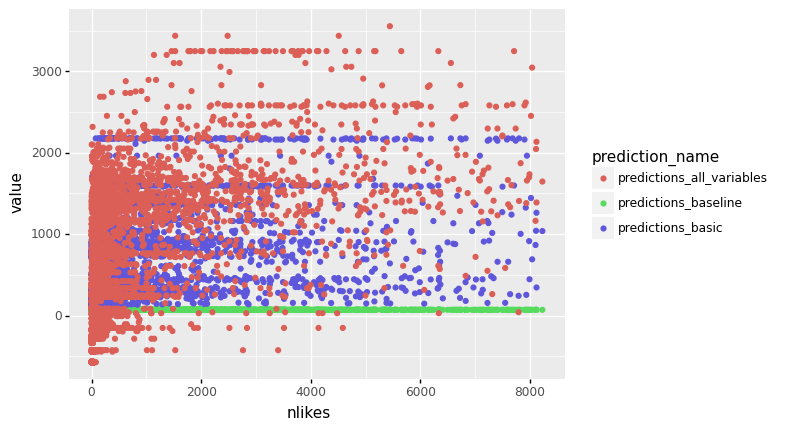

In [100]:
graph_data = pd.melt(val[[target, 'is_large'] + prediction_cols], [target, 'is_large'], var_name='prediction_name')

graph = (
    pn.ggplot(graph_data, pn.aes(x=target, y='value', color='prediction_name'))
    + pn.geom_point()
    + pn.xlim(0, val[target].quantile(0.95))
)

graph.draw();

In [103]:
val[[target] + prediction_cols].corr()[target]

nlikes                       1.000000
predictions_baseline              NaN
predictions_basic            0.195145
predictions_all_variables    0.317356
Name: nlikes, dtype: float64

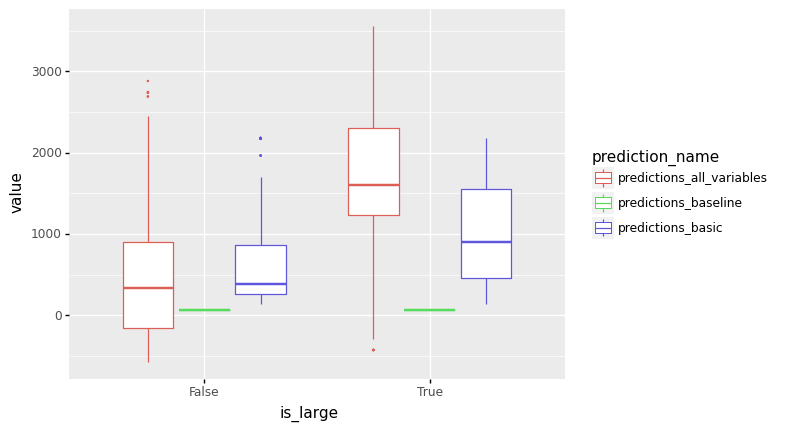

In [101]:
graph = (
    pn.ggplot(graph_data, pn.aes(x='is_large', y='value', color='prediction_name'))
    + pn.geom_boxplot(outlier_size=0)
)

graph.draw();

Podemos apreciar en estos 2 graficos 2 cosas:

* El baseline parece muy relevante para los valores bajos del target, pero cuando sube, ya no tiene ningun sentido --> esto se traduce en una correlacion mucho mejor para el modelo mas complejo
* Estamos prediciendo valores negativos con nuestro modelo complejo!

Lo de predecir valores negativos no es tan problematico - en realidad podriamos capar el valor minimo en 0 y andando.

In [104]:
prediction_cols

['predictions_baseline', 'predictions_basic', 'predictions_all_variables']

In [109]:
val['predictions_all_variables_capped'] = val.predictions_all_variables.clip(lower=0)

print(median_absolute_error(val[target], val['predictions_all_variables_capped']))
print(median_absolute_error(val.loc[~c, target], val.loc[~c, 'predictions_all_variables_capped']).round())
print(median_absolute_error(val.loc[c, target], val.loc[c, 'predictions_all_variables_capped']).round())

378.3386700033152
270.0
1566.0


Mejora ligeramente los resultados del modelo.

Otra cosa que podriamos hacer en este sentido es remplazar valores "bajos" por nuestro baseline - pero ojo - no podemos mirar el target! Miramos a ver si predecimos por debajo del cuantil 80% del train

In [110]:
val['predicted_low'] = val['predictions_all_variables_capped'] < train[target].quantile(0.8)

val['predictions_all_variables_capped_combine_baseline'] = val.predictions_all_variables_capped
val.loc[(val.predictions_all_variables_capped_combine_baseline > 0) & val.predicted_low, 'predictions_all_variables_capped_combine_baseline'] = baseline_median

In [111]:
print(median_absolute_error(val[target], val['predictions_all_variables_capped_combine_baseline']))
print(median_absolute_error(val.loc[~c, target], val.loc[~c, 'predictions_all_variables_capped_combine_baseline']).round())
print(median_absolute_error(val.loc[c, target], val.loc[c, 'predictions_all_variables_capped_combine_baseline']).round())

347.7321953984356
88.0
1595.0


Pues hemos mejorado algo pero no mucho!

### Influencia de las variables
Otra cosa interesante es ver como influyen las diferentes variables sobre la regresion

In [117]:
[(col, coef) for col, coef in zip([col for col in FINAL_COLS if col != target], lin_reg_all.coef_)]

[('video', 234.9563775541368),
 ('has_quotes', -135.39887621285033),
 ('verified', 344.359172490941),
 ('join_datetime_year', 128.14640283899524),
 ('followers_binned', -81.00522764753394),
 ('likes_per_tweets_binned', -53.495856701721586),
 ('followers_per_tweets_binned', 330.3019830771135),
 ('number_tweets_in_period', -0.7095464168642042),
 ('tweets_capped', -0.0021162291741919047),
 ('followers_capped', 4.007127404788927e-05)]

Aqui podemos apreciar varias cosas:

* Las variables que influyen de forma positiva, por ejemplo si es verificado
* La escala - pero aqui es dificil comparar porque las variables no estan normalizadas!
* Lo malo de incluir tantas variables! Vemos que followers reduce por un lado pero sube por otro - esto pasara por tener demasiadas

### Un modelo mas poderoso
Solo para ver que tal - vamos a entrenar un random forest.

In [121]:
variables = [col for col in FINAL_COLS if col != target]
model = RandomForestRegressor(random_state=1)
model.fit(train[variables], train[target])

predictions_name = 'predictions_rf'
train[predictions_name] = model.predict(train[variables])
val[predictions_name] = model.predict(val[variables])

train_error = median_absolute_error(train[target], train[predictions_name])
val_error = median_absolute_error(val[target], val[predictions_name])
print(f'We had a training score of {train_error} and a validation score of {val_error}')

print(median_absolute_error(val.loc[~c, target], val.loc[~c, 'predictions_rf']).round())
print(median_absolute_error(val.loc[c, target], val.loc[c, 'predictions_rf']).round())

We had a training score of 55.33466200030249 and a validation score of 83.5732966179157
42.0
1711.0


In [122]:
prediction_cols.append('predictions_rf')

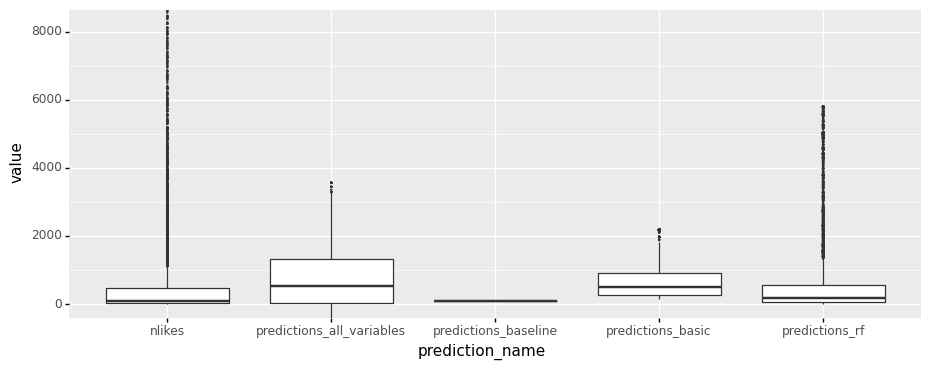

In [127]:
graph_data = pd.melt(val[[target, 'is_large'] + prediction_cols], 'is_large', var_name='prediction_name')

graph = (
    pn.ggplot(graph_data, pn.aes(x='prediction_name', y='value'))
    + pn.geom_boxplot(outlier_size=0)
    + pn.coord_cartesian(ylim=(0, val[target].quantile(0.95)))
    + pn.theme(figure_size=(11, 4))
)

graph.draw();

In [128]:
val[[target] + prediction_cols].corr()[target]

nlikes                       1.000000
predictions_baseline              NaN
predictions_basic            0.195145
predictions_all_variables    0.317356
predictions_rf               0.444962
Name: nlikes, dtype: float64

Podemos ver que:

* Para los valores mas pequeños conseguimos mejorar mucho y esto hace que el score y correlacion mejoran mucho en general
* Para los valores grandes no hay mucha diferencia
* La distribucion de valores que predecimos parece mucho mas similar a la distribucion original del target
* Vemos que tambien hay bastante diferencia entre el score para train y validacion - esto es un problema comun de los modelos poderosos que se llama overfitting.

En general es dificil evaluar bien problemas de regresion - pero definitivamente nuestro modelo poderoso ha mejorado bastante la prediccion. 

Sin ir demasiado lejos - nos acordamos de que queremos entender si un tweet va a ser popular o no. Entonces, podriamos decir que si predicimos que un tweet va a tener un cierto numero de likes, va a ser popular. Vamos a intentar evaluar esto directamente, ya que parece lo mas relevante. Como el umbral, vamos a coger el percentil 80% de train. Comparamos si el tweet de val fue popular y si predecimos que va a ser popular.


In [135]:
is_popular_val = val[target] > train[target].quantile(0.8)
is_popular_pred = val[prediction_cols] > train[target].quantile(0.8)

for col in prediction_cols:
    print(col, (is_popular_val == is_popular_pred[col]).mean().round(2))

predictions_baseline 0.76
predictions_basic 0.6
predictions_all_variables 0.68
predictions_rf 0.86


Otra vez parece ser que el baseline es bastante bueno! Pero esto no cuenta - porque predice lo mismo para todos los tweets (que van a ser poco populares), asi que es totalmente inutil. Aqui si que vemos que el random forest ha mejorado las cosas bastante.

### Test
Como ultima tarea, vamos a predicir sobre test - utilizaremos nuestro random forest ya que tiene tan buena pinta la prediccion.

In [137]:
test[predictions_name] = model.predict(test[variables])
test['is_large'] = test[target] > train[target].quantile(0.8)
c = test.is_large

test_error = median_absolute_error(test[target], test[predictions_name])
print(f'We had a test score of {test_error}')

print(median_absolute_error(test.loc[~c, target], test.loc[~c, 'predictions_rf']).round())
print(median_absolute_error(test.loc[c, target], test.loc[c, 'predictions_rf']).round())

We had a test score of 72.63585499627548
41.0
1104.0


Muy bien! Algo muy similar a los datos de validacion.

## Ultimos comentarios
Hemos profundizado bastante en esta parte de la evaluacion - mucho mas de lo que se esperaba de vosotros (de hecho, la mayoria de los proyectos entregados tuvieron un 100% en la parte de evaluacion). Esto lo he hecho porque realmente es lo mas importante de cualquier modelo y podemos ser bastante creativos a la hora de hacer este proceso.